# Clasificación de imagenes de hojas utilizando un modelo pre entrenado de ViT de Huggingface.

---

# Modelo:

## DeiT (Data-efficient Image Transformer) 
(https://huggingface.co/facebook/deit-base-patch16-224)
- **Tipo:** Vision Transformer (ViT) optimizado para eficiencia de datos.
- **Características:**
  - Basado en el estándar ViT con atención global.
  - Entrenado sin necesidad de grandes cantidades de datos, gracias a técnicas de distillation (knowledge distillation).
  - Tamaño de patch: 16×16, resolución de entrada: 224×224.

# Datos:

## Plant Diseases Dataset
(https://huggingface.co/datasets/fakewave07/plant-diseases-dataset)
- **Tipo:** Dataset de clasificación de imágenes.
- **Características:**
  - Contiene imágenes de hojas de plantas clasificadas como sanas o con distintas enfermedades.
  - Incluye 38 clases en total.
  - Cada imagen está etiquetada con la enfermedad correspondiente.
  - Diseñado para tareas de diagnóstico automatizado en agricultura mediante visión por computadora.

---
---

## Introducción

En el siguiente trabajo se abordará la tarea de clasificación de imágenes de hojas utilizando un modelo de visión por computadora preentrenado disponible en la plataforma HuggingFace. El objetivo principal es evaluar el desempeño del modelo en la detección de diferentes tipos de enfermedades en plantas a partir de imágenes.

Para ello, se llevarán a cabo dos experimentos principales:

1. Una clasificación utilizando el modelo tal como fue preentrenado (sin ajustes adicionales).

2. Una segunda clasificación en la que se aplicará fine-tuning, es decir, un ajuste del modelo a partir de los datos específicos del conjunto de imágenes de hojas.

Finalmente, se realizará una comparación de los resultados obtenidos en ambos enfoques con el fin de analizar el impacto del fine-tuning en el rendimiento del modelo y su capacidad de generalización.

---

# Desarrollo

In [1]:
from huggingface_hub import login
from dotenv import load_dotenv
import os
from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import gc

c:\Proyectos\vision-transformer-classifier\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

cuda


## Logueo en HaggingFace

In [3]:
load_dotenv()
token = os.getenv("HUGGINGFACE_HUB_TOKEN")

login(token=token)

## Preparación de los datos

In [4]:
dataset_dir = load_dataset("fakewave07/plant-diseases-dataset")

In [5]:
print(dataset_dir)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 23112
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 33
    })
})


Si bien el conjunto de datos original ya se encontraba dividido en particiones de entrenamiento y prueba (train y test), se optó por unificar todos los datos en un único dataset y realizar manualmente una nueva división en entrenamiento, validación y prueba. Esta decisión se tomó con el objetivo de tener un mayor control sobre la distribución de las clases en cada subconjunto y garantizar una evaluación más equilibrada y representativa del modelo. Además, contar con un conjunto de validación separado permite ajustar hiperparámetros y evaluar el modelo durante el entrenamiento sin afectar la objetividad de los resultados finales obtenidos en la prueba.

In [6]:
full_dataset = concatenate_datasets([dataset_dir["train"], dataset_dir["test"]])

In [7]:
split1 = full_dataset.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
temp_train = split1["train"]
data_test = split1["test"]

split2 = temp_train.train_test_split(test_size=0.1, stratify_by_column="label", seed=42)
data_train = split2["train"]
data_valid = split2["test"]

In [8]:
data_test_original =  Dataset.from_dict(data_test[:])
data_train_original =  Dataset.from_dict(data_test[:])
data_valid_original =  Dataset.from_dict(data_valid[:])

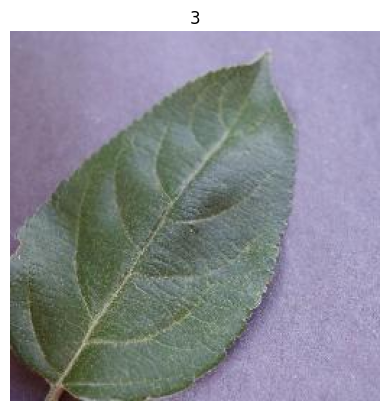

In [9]:
sample = data_train[0]
plt.imshow(sample['image'])
plt.title(sample['label'])
plt.axis("off")
plt.show()

In [10]:
# Verificar tamaños
print(f"Train size: {len(data_train)}")
print(f"Test size: {len(data_test)}")
print(f"Validate size: {len(data_valid)}")

Train size: 16664
Test size: 4629
Validate size: 1852


In [13]:
labels = data_train.features['label'].names
print(labels)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

## Preparación del modelo preentrenado

In [14]:
selected_model = 'facebook/deit-base-patch16-224'
processor = AutoImageProcessor.from_pretrained(selected_model)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [15]:
num_labels = len(labels)

# Adaptamos el modelo
model = AutoModelForImageClassification.from_pretrained(
    selected_model,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([38, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([38]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Data Augmentation

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
])

In [17]:
def transform_dataset(example, transform=None):
    image = example['image']

    if transform:
        image = transform(image)

    inputs = processor(images=image, return_tensors="pt")
    example['pixel_values'] = inputs['pixel_values'].squeeze()
    example['label'] = example['label']

    return example

In [18]:
data_train = data_train.map(lambda x: transform_dataset(x, transform), batched=False)
data_valid = data_valid.map(lambda x:transform_dataset(x), batched=False)
data_test = data_test.map(lambda x: transform_dataset(x), batched=False)

In [19]:
torch.cuda.empty_cache()
gc.collect()

3044

In [20]:
def collate_fn(batch):
    pixel_values = [item['pixel_values'] for item in batch]
    labels = [item['label'] for item in batch]
    return {
        'pixel_values': torch.stack(pixel_values),
        'labels': torch.tensor(labels)
    }

In [21]:
eval_dataloader = DataLoader(data_test, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [22]:
data_test

Dataset({
    features: ['image', 'label', 'pixel_values'],
    num_rows: 4629
})

In [23]:
data_train.set_format(type='torch', columns=['pixel_values','label'])
data_valid.set_format(type='torch', columns=['pixel_values', 'label'])
data_test.set_format(type='torch', columns=['pixel_values','label'])

## Evaluación del modelo pre entrenado

In [24]:
def evaluate_model(model, dataloader, labels, dataset_raw, device='cpu'):
    model.eval()
    model.to(device)

    all_predictions = []
    all_labels = []
    
    # Para las primeras imágenes
    images_to_show = []
    predictions_to_show = []
    labels_to_show = []

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            pixel_values = batch['pixel_values'].to(device)
            labels_batch = batch['labels'].to(device)

            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())

            if i < 1:
                for j in range(min(15, len(labels_batch))):
                    images_to_show.append(dataset_raw[i * dataloader.batch_size + j]['image'])
                    predictions_to_show.append(predictions[j].item())
                    labels_to_show.append(labels_batch[j].item())

    # Convertimos a numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Detectar clases presentes en los datos
    present_class_indices = sorted(np.unique(np.concatenate([all_labels, all_predictions])))
    present_class_names = [labels[i] for i in present_class_indices]
    
    # Métricas
    acc = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='macro')
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, labels=present_class_indices, target_names=present_class_names))

    # Mostrar imágenes
    plt.figure(figsize=(20, 10))
    for i in range(len(images_to_show)):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images_to_show[i])
        plt.title(f"Pred: {labels[predictions_to_show[i]]}\nTrue: {labels[labels_to_show[i]]}")
        plt.axis('off')
    plt.suptitle("Predicciones vs. Etiquetas verdaderas (primeras 15 imágenes)", fontsize=16)
    plt.tight_layout()
    plt.show()


c:\Proyectos\vision-transformer-classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Proyectos\vision-transformer-classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Proyectos\vision-transformer-classifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Accuracy: 0.0181
F1 Score (macro): 0.0091
Precision (macro): 0.0208
Recall (macro): 0.0219

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00       404
                                 Apple___Black_rot       0.12      0.01      0.01       397
                          Apple___Cedar_apple_rust       0.01      0.00      0.00       353
                                   Apple___healthy       0.00      0.00      0.00       402
                               Blueberry___healthy       0.00      0.00      0.00       363
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00       337
                 Cherry_(including_sour)___healthy       0.01      0.01      0.01       365
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.40      0.01      0.01       328
                       Corn_(maize)___Common_rust_      

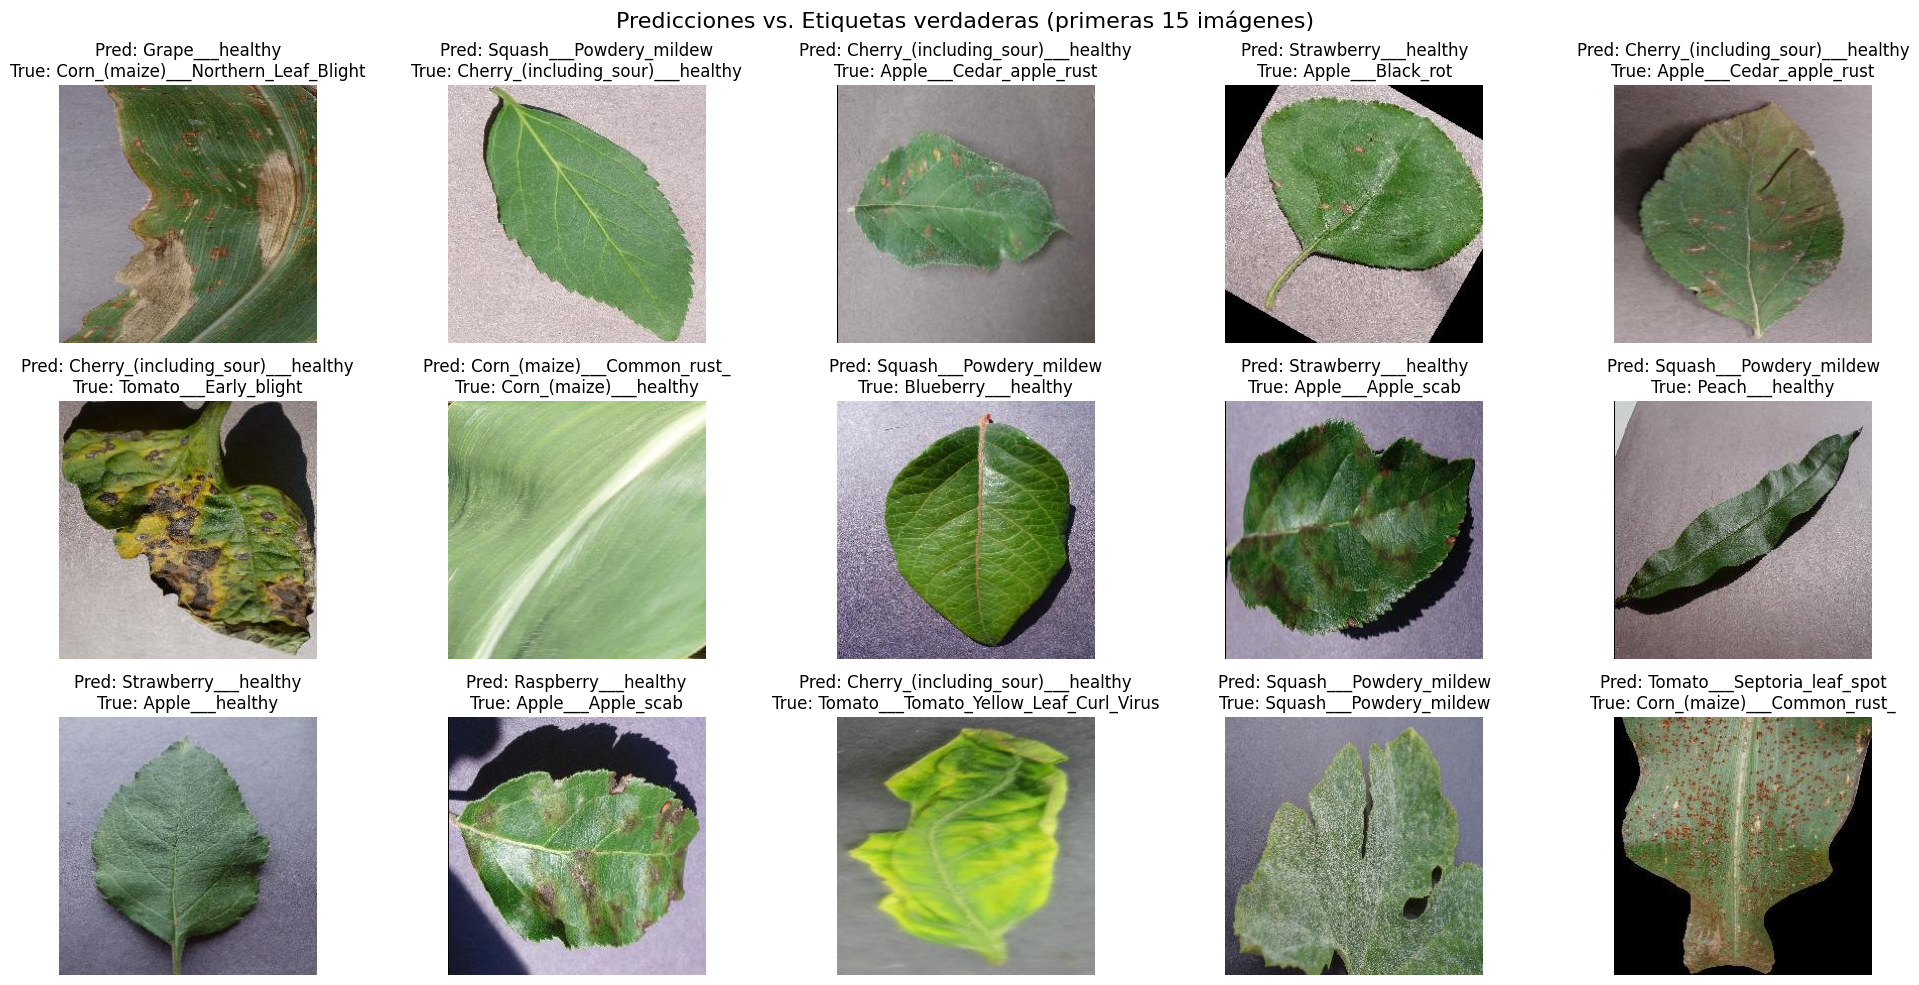

In [25]:
evaluate_model(
    model=model,
    dataloader=eval_dataloader,
    labels=labels,
    dataset_raw=data_test_original,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


In [26]:
torch.cuda.empty_cache()
gc.collect()

31839

## Fine-tuning del modelo

In [27]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16, 
    num_train_epochs=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    fp16=True
)

In [28]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_train,
    eval_dataset=data_valid,
    tokenizer=processor,
    compute_metrics=compute_metrics
)

C:\Users\caro_\AppData\Local\Temp\ipykernel_31420\2436116264.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [30]:
trainer.train()

TrainOutput(global_step=5210, training_loss=0.05907843779922676, metrics={'train_runtime': 2838.9804, 'train_samples_per_second': 29.349, 'train_steps_per_second': 1.835, 'total_flos': 6.458715849886433e+18, 'train_loss': 0.05907843779922676, 'epoch': 5.0})

## Evaluación del modelo con Fine-tuning

In [31]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.027678722515702248, 'eval_accuracy': 0.9951403887688985, 'eval_runtime': 40.8198, 'eval_samples_per_second': 45.37, 'eval_steps_per_second': 2.842, 'epoch': 5.0}


In [32]:
torch.cuda.empty_cache()

Accuracy: 0.9937
F1 Score (macro): 0.9829
Precision (macro): 0.9839
Recall (macro): 0.9831

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00       404
                                 Apple___Black_rot       1.00      1.00      1.00       397
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       353
                                   Apple___healthy       1.00      1.00      1.00       402
                               Blueberry___healthy       1.00      1.00      1.00       363
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       337
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       365
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       1.00      0.96      0.98       328
                       Corn_(maize)___Common_rust_      

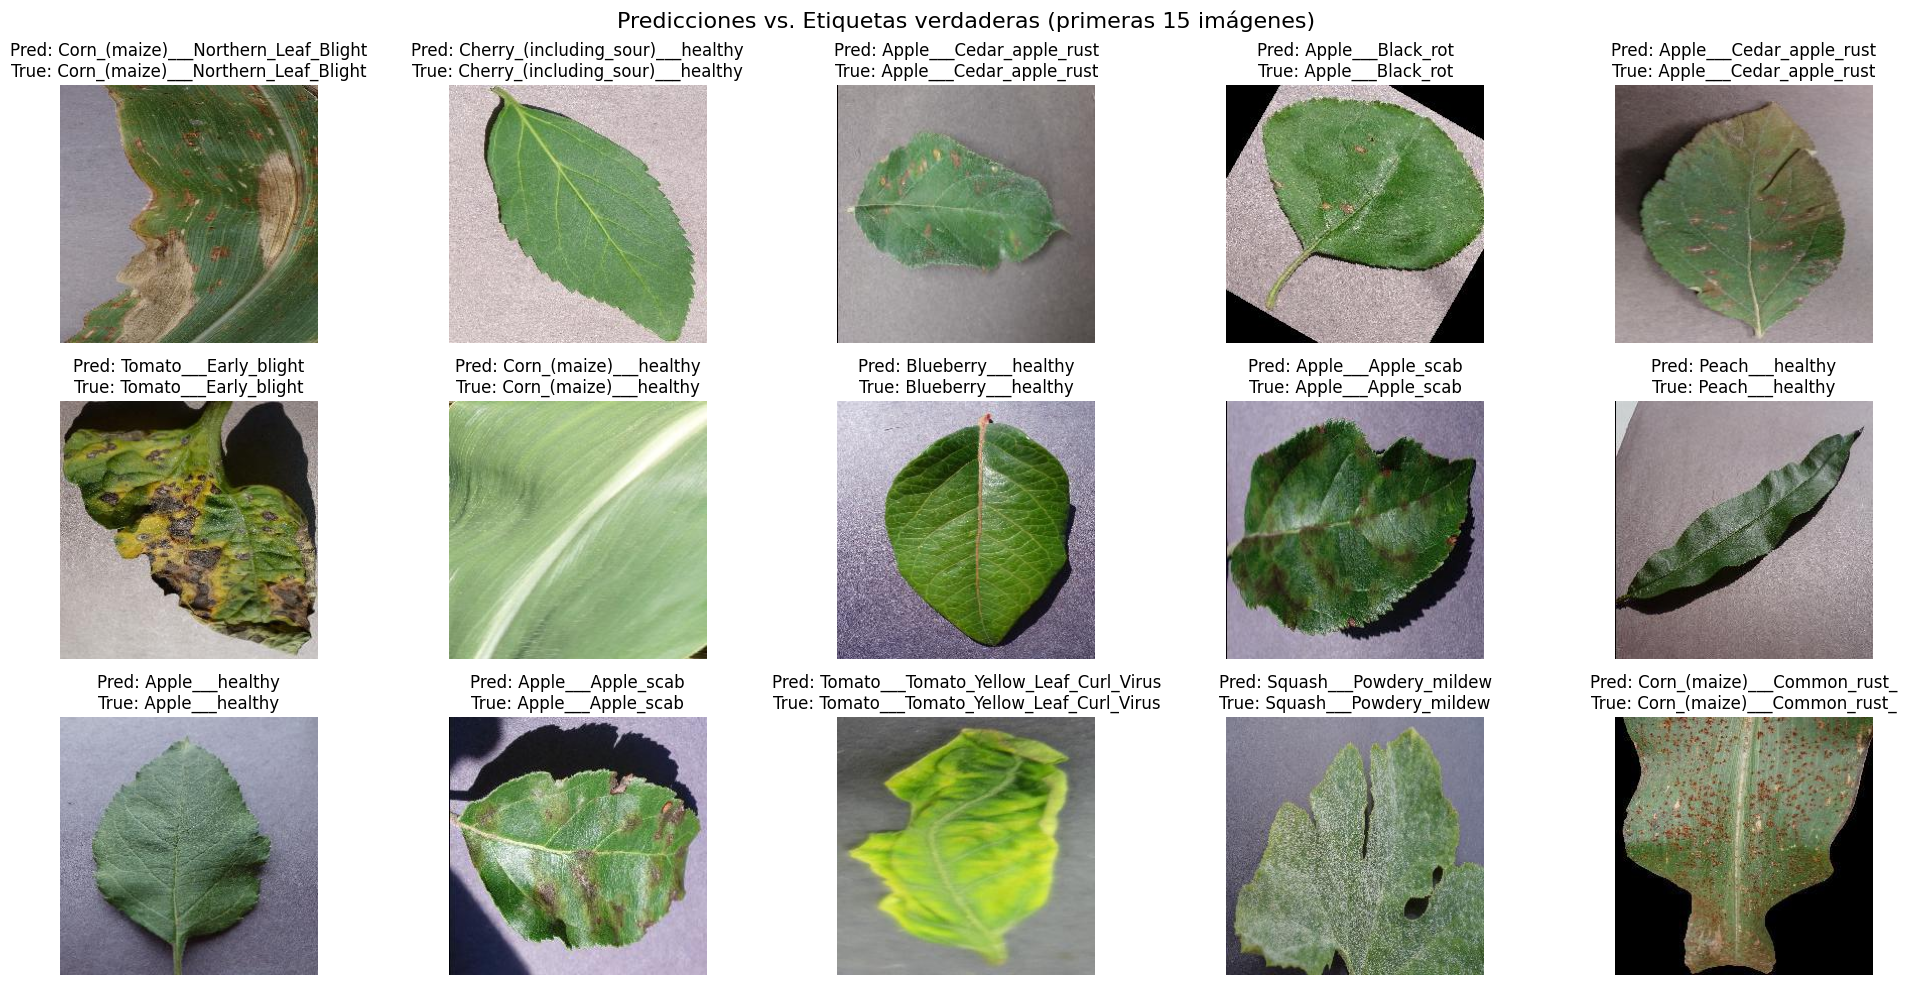

In [33]:
evaluate_model(
    model=model,
    dataloader=eval_dataloader,
    labels=labels,
    dataset_raw=data_test_original,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


---

## Análisis

### 1. Justifique la elección del modelo preentrenado y del dataset.


Modelo preentrenado seleccionado: **facebook/deit-base-patch16-224**

**Justificación:**
- ViT eficiente y ligero: El modelo DeiT (Data-efficient Image Transformer) es una variante del Vision Transformer entrenada con una estrategia más eficiente, permitiendo buenos resultados en clasificación de imágenes con menos datos etiquetados.

- Preentrenamiento generalizado: Está preentrenado en ImageNet, lo cual lo hace apto para transfer learning en tareas de clasificación de imágenes naturales, como es el caso de enfermedades en hojas de plantas.

- Arquitectura versátil: Como modelo basado en atención, no depende tanto de la localización espacial como las CNNs, lo que puede ser útil con imágenes de hojas que presentan patrones en distintas regiones.

Dataset utilizado: **fakewave07/plant-diseases-dataset**

**Justificación:**

- Multiclase y multiespecie: Cubre múltiples cultivos (manzana, uva, maíz, etc.) y diversas enfermedades, lo que representa un desafío realista y diverso para un modelo de clasificación.

- Aplicación práctica relevante: La identificación automática de enfermedades vegetales tiene un valor real en agricultura, lo que justifica experimentar con este tipo de datos.

### 2. Explique el proceso de fine-tuning realizado, especificando los parámetros ajustados y las modificaciones necesarias.


Modificaciones al modelo:

- Adaptación de la capa de salida: Se cambió la capa final del modelo para que se adapte al número de clases en el dataset (num_labels = len(labels)).

- ignore_mismatched_sizes=True: Esto permite reemplazar la capa final preentrenada (pensada para ImageNet con 1000 clases) por una nueva, sin errores por discrepancias de tamaño.

Transformaciones aplicadas a los datos:

- Aumento de datos en entrenamiento:

   - RandomHorizontalFlip y RandomRotation(15°): Técnicas comunes para mejorar la robustez del modelo a variaciones espaciales.

- Normalización automática por el AutoImageProcessor: Adapta las imágenes a lo que espera el modelo preentrenado (tamaño, canales, normalización).

Parámetros de entrenamiento (TrainingArguments):

- learning_rate=2e-5: Pequeño para evitar sobreajustar la base preentrenada demasiado rápido.

- num_train_epochs=5: Suficientes para ver mejoras sin sobreentrenamiento.

- per_device_train_batch_size=16: Equilibrio entre estabilidad y uso de memoria GPU.

- eval_strategy="epoch" + load_best_model_at_end=True: Evalúa cada época y guarda el mejor modelo según rendimiento en validación.

- fp16=True: Uso de media precisión para acelerar el entrenamiento en GPU compatibles.

### 3. Evalúe el rendimiento del modelo preentrenado sin ajustes y compárelo con los resultados obtenidos tras el fine-tuning, discutiendo las mejoras o diferencias observadas.

#### Modelo preentrenado (sin fine-tuning):
- **Accuracy:** 0.0181
- **F1 Score (macro):** 0.0091
- **Precision (macro):** 0.0208
- **Recall (macro):** 0.0219

**Interpretación:**
- El modelo no tiene conocimiento específico sobre las clases del dataset.
- Aunque está preentrenado en ImageNet, no logra generalizar a la tarea de clasificación de enfermedades en hojas de plantas.
- El rendimiento es prácticamente aleatorio, con una ligera predilección por algunas clases (e.g. Grape___healthy con alto recall pero bajo f1-score).
- No es útil en esta forma para una tarea de clasificación real.


#### Modelo tras fine-tuning:
- **Accuracy:** 0.9937
- **F1 Score (macro):** 0.9829
- **Precision (macro):** 0.9839
- **Recall (macro):** 0.9831

**Interpretación:**
- Después del fine-tuning con imágenes reales de hojas y enfermedades, el modelo ajusta sus pesos para reconocer patrones específicos.
- Se observa una mejora sustancial y consistente en todas las métricas.
- El modelo clasifica correctamente incluso clases minoritarias (de solo 20 imágenes), manteniendo alta precisión y recall.
- El rendimiento es excelente y demuestra la eficacia del aprendizaje por transferencia en tareas de clasificación especializada.


#### 📊 Comparación resumen:

| Métrica     | Preentrenado | Fine-tuned |
|-------------|--------------|------------|
| Accuracy    | 0.0181       | 0.9937     |
| F1 Macro    | 0.0091       | 0.9829     |
| Precision   | 0.0208       | 0.9839     |
| Recall      | 0.0219       | 0.9831     |


---

## Conclusión:
El fine-tuning transforma un modelo genérico en una herramienta altamente especializada para la clasificación de enfermedades en plantas. Las mejoras son evidentes y cuantificables en todos los aspectos.

---
---